# Project: Insurance Policy Cancellation (CC)
---------------------------------------------


*This dataset comes from the 2022 NESS Statathon (Theme 1) from 2022.*

**Challenge:** Using historical policy data, create a multiclass predictive model to predict the policies that are most likely to be canceled and those most likely to be renewed, as well as understand what variables are most influential in causing a policy cancellation.

For this theme, there are true answers, and a team should focus on proposing the best predictive model. The performance of a team will be mainly based on the predictive performance of the propose method measured by accuracy and the quality of the code. You can use Python's weighted F1 score to calculate the performance of for your model on the test partition.


# Dataset Description
The Kangaroo data set is based on 4 years of property insurance policies from 2013 to 2017. There are roughly 1 million policies in the training data and each policy only has one observation. There were almost 230,000 policies canceled during the effective term. Your work is to build a model on the training data and use your best model to predict the cancelation indicator for each policy in test data.

Variable descriptions
* id - Policy id (cannot be used in model)
* tenure - Number of years with Kangaroo
* claim.ind - Occurrence of claim (0=no, 1=yes)
* n.adults - Number of adults in the property
* n.children - Number of children in the property
* ni.gender - Gender of policyholder
* ni.marital.status - Marital status of policyholder (0=no, 1=yes)
* premium - Price of the policy
* sales.channel - Medium through which policy was purchased
* coverage.type - Type of coverage
* dwelling.type - Type of dwelling
* len.at.res - Length at residence (how long policyholder lived at property)
* credit - Financial credit level of policyholder
* house.color - Color of house
* ni.age - Age of policholder
* year - Year of the policy
* zip.code - Zip code of the property
* cancel - cancelation indicator (0=not cancel, 1=may cancel but can be convinced, 2=cancel). **This is the response variable.** Dave is deleting the rows where `cancel==-1`!

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=9c9556fa7817db400a1d807706166a16ef1c58770840ea4b3a74cda08c6610de
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .appName("Project_3")\
        .getOrCreate()

In [3]:
# our usual pyspark friends
from pyspark.sql.utils import AnalysisException
import pyspark.sql.functions as F
import pyspark.sql.types as T
from functools import reduce

In [4]:
# pandas
import pandas as pd

In [5]:
!pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [6]:
#train_df : https://drive.google.com/file/d/1ALi1coNsEFepkvB_19YGNMjd89OdtqwA/view?usp=share_link
#test_df : https://drive.google.com/file/d/1AISuYnBX7X-joDfO_Byi_MXrRl4tg2FJ/view?usp=share_link

!gdown 1ALi1coNsEFepkvB_19YGNMjd89OdtqwA
!gdown 1AISuYnBX7X-joDfO_Byi_MXrRl4tg2FJ

Downloading...
From: https://drive.google.com/uc?id=1ALi1coNsEFepkvB_19YGNMjd89OdtqwA
To: /content/train_df_simple (1).csv
100% 11.2M/11.2M [00:00<00:00, 63.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AISuYnBX7X-joDfO_Byi_MXrRl4tg2FJ
To: /content/test_df (1).csv
100% 32.2M/32.2M [00:00<00:00, 60.7MB/s]


In [7]:
train_df = spark.read.option("inferSchema", "true").csv("./train_df_simple (1).csv", multiLine=True, header=True)
test_df  = spark.read.option("inferSchema", "true").csv("./test_df (1).csv", multiLine=True, header=True)

## Train

In [8]:
train_df.show()

+-------+----+--------+-----------+------+----------+------+-------------+-------------+-----------------+-------------+---------+-----------------+--------+----------+------+---------+------+
|     id|year|zip.code|house.color|ni.age|len.at.res|credit|coverage.type|dwelling.type|          premium|sales.channel|ni.gender|ni.marital.status|n.adults|n.children|tenure|claim.ind|cancel|
+-------+----+--------+-----------+------+----------+------+-------------+-------------+-----------------+-------------+---------+-----------------+--------+----------+------+---------+------+
| 688609|2016| 50001.0|      white|  44.0|      25.0|  high|            A|        Condo|      950.7386189|       Broker|        F|              1.0|     3.0|       0.0|  17.0|      0.0|     0|
| 308155|2015| 50048.0|     yellow|  31.0|      22.0|  high|            B|       Tenant|      1003.420558|       Broker|        M|              0.0|     2.0|       0.0|   8.0|      1.0|     0|
| 240486|2015| 98034.0|      white|

## Test

In [9]:
test_df.show()

+-------+----+--------+-----------+------+-----------+------+-------------+-------------+-----------------+-------------+---------+-----------------+--------+----------+------+---------+------+
|     id|year|zip.code|house.color|ni.age| len.at.res|credit|coverage.type|dwelling.type|          premium|sales.channel|ni.gender|ni.marital.status|n.adults|n.children|tenure|claim.ind|cancel|
+-------+----+--------+-----------+------+-----------+------+-------------+-------------+-----------------+-------------+---------+-----------------+--------+----------+------+---------+------+
| 812304|2013| 50020.0|      white|  33.0|       16.0|  high|            C|        House|       796.385532|       Broker|        F|              1.0|     1.0|       3.0|   2.0|      1.0|     0|
| 304035|2013| 80002.0|        red|  56.0|       10.0|  high|            A|        House|      773.2326869|       Broker|        M|              1.0|     2.0|       0.0|  14.0|      0.0|     0|
|  88142|2015| 85005.0|      w

#Cleaning

## Cleaning column names

In [10]:
# Knowing the train dataframe
train_pd = pd.read_csv("./train_df_simple (1).csv")
print(train_pd.shape)
train_pd.describe()

(120000, 18)


,id,year,zip.code,ni.age,len.at.res,premium,ni.marital.status,n.adults,n.children,tenure,claim.ind,cancel
count,1.200000e+05,120000.000000,119879.000000,119867.000000,119887.000000,119898.000000,119882.000000,119908.000000,119904.000000,119876.000000,119872.000000,120000.000000
mean,5.247257e+05,2014.629933,62436.796036,43.545704,15.198150,899.821112,0.708121,2.134695,1.736981,11.659173,0.199121,0.509033
std,3.029068e+05,1.109712,27976.004223,12.379807,4.556148,77.786890,0.454629,1.249736,2.350064,5.932513,0.399341,0.828879
min,5.000000e+00,2013.000000,15001.000000,18.000000,2.000000,614.761883,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.632772e+05,2014.000000,50009.000000,35.000000,12.000000,843.660298,0.000000,1.000000,0.000000,6.000000,0.000000,0.000000
50%,5.240505e+05,2015.000000,80011.000000,43.000000,15.000000,899.592782,1.000000,2.000000,1.000000,13.000000,0.000000,0.000000
75%,7.868630e+05,2016.000000,85030.000000,51.000000,18.000000,955.452278,1.000000,3.000000,3.000000,16.000000,0.000000,1.000000
max,1.048551e+06,2016.000000,98038.000000,318.677396,49.988155,1235.480942,1.000000,10.000000,12.000000,32.000000,1.000000,2.000000


Here, we clean the column names of both the training and test data set where we replace the '.' in the column names with '_'.

## Train

In [11]:
# Cleaning the column names in training dataset
for col in train_df.columns:
    new_col = col.replace('-', '_').replace('.', '_')
    train_df = train_df.withColumnRenamed(col, new_col)

In [12]:
train_df.show(20, False)

+-------+----+--------+-----------+------+----------+------+-------------+-------------+-----------------+-------------+---------+-----------------+--------+----------+------+---------+------+
|id     |year|zip_code|house_color|ni_age|len_at_res|credit|coverage_type|dwelling_type|premium          |sales_channel|ni_gender|ni_marital_status|n_adults|n_children|tenure|claim_ind|cancel|
+-------+----+--------+-----------+------+----------+------+-------------+-------------+-----------------+-------------+---------+-----------------+--------+----------+------+---------+------+
|688609 |2016|50001.0 |white      |44.0  |25.0      |high  |A            |Condo        |950.7386189      |Broker       |F        |1.0              |3.0     |0.0       |17.0  |0.0      |0     |
|308155 |2015|50048.0 |yellow     |31.0  |22.0      |high  |B            |Tenant       |1003.420558      |Broker       |M        |0.0              |2.0     |0.0       |8.0   |1.0      |0     |
|240486 |2015|98034.0 |white      |

## Test

In [13]:
# Cleaning the column names in training dataset
for col in test_df.columns:
    new_col = col.replace('-', '_').replace('.', '_')
    test_df = test_df.withColumnRenamed(col, new_col)

In [14]:
test_df.show(20, False)

+-------+----+--------+-----------+------+-----------+------+-------------+-------------+-----------------+-------------+---------+-----------------+--------+----------+------+---------+------+
|id     |year|zip_code|house_color|ni_age|len_at_res |credit|coverage_type|dwelling_type|premium          |sales_channel|ni_gender|ni_marital_status|n_adults|n_children|tenure|claim_ind|cancel|
+-------+----+--------+-----------+------+-----------+------+-------------+-------------+-----------------+-------------+---------+-----------------+--------+----------+------+---------+------+
|812304 |2013|50020.0 |white      |33.0  |16.0       |high  |C            |House        |796.385532       |Broker       |F        |1.0              |1.0     |3.0       |2.0   |1.0      |0     |
|304035 |2013|80002.0 |red        |56.0  |10.0       |high  |A            |House        |773.2326869      |Broker       |M        |1.0              |2.0     |0.0       |14.0  |0.0      |0     |
|88142  |2015|85005.0 |white  

## Cleaning Data

The code written below is to identify and verify the binary columns.

In [15]:
# Getting the binary and verifying them
is_binary = train_df.agg(*[(F.size(F.collect_set(x)) == 2).alias(x) for x in train_df.columns]).toPandas()
is_binary

,id,year,zip_code,house_color,ni_age,len_at_res,credit,coverage_type,dwelling_type,premium,sales_channel,ni_gender,ni_marital_status,n_adults,n_children,tenure,claim_ind,cancel
0,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False


In [16]:
train_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- zip_code: double (nullable = true)
 |-- house_color: string (nullable = true)
 |-- ni_age: double (nullable = true)
 |-- len_at_res: double (nullable = true)
 |-- credit: string (nullable = true)
 |-- coverage_type: string (nullable = true)
 |-- dwelling_type: string (nullable = true)
 |-- premium: double (nullable = true)
 |-- sales_channel: string (nullable = true)
 |-- ni_gender: string (nullable = true)
 |-- ni_marital_status: double (nullable = true)
 |-- n_adults: double (nullable = true)
 |-- n_children: double (nullable = true)
 |-- tenure: double (nullable = true)
 |-- claim_ind: double (nullable = true)
 |-- cancel: integer (nullable = true)



The below code divides it into binary, nomial and continous.

In [17]:
# dividing the columns into binary, nomial, and continuous variables
column_details = train_df.agg(*[(F.size(F.collect_set(x))).alias(x) for x in train_df.columns]).toPandas()
column_details

,id,year,zip_code,house_color,ni_age,len_at_res,credit,coverage_type,dwelling_type,premium,sales_channel,ni_gender,ni_marital_status,n_adults,n_children,tenure,claim_ind,cancel
0,120000,4,310,4,166,2436,3,3,3,119896,3,2,2,10,13,33,2,3


I have defined the Identifiers, binary columns, nominal columns, continuous variable and target variable.

In [18]:
IDENTIFIERS = ['id']
BINARY_COlUMNS = ["ni_gender", "claim_ind", "ni_marital_status"]
NOMINAL_COLUMNS = ["year", "zip_code", "house_color", "credit", "coverage_type",  "dwelling_type", "sales_channel" ]
CONTINUOUS_VARIABLE = ["premium", "ni_age", "len_at_res", "n_adults",	"n_children", "tenure"	 ]
TARGET_VARIABLE = ['cancel']

### Deleting all the rows where all the cells are null

Here, I am dropping all the rows in the train and test data set where all cells in the rows are null.

## Train

In [19]:
# deleting all the rows where all the cells are null
train_df = train_df.dropna(
    how="all",
    subset=[x for x in train_df.columns if x not in IDENTIFIERS], # this is just a list of all columns except identifiers
)

In [20]:
print(train_df.count(), len(train_df.columns))

120000 18


From above, I can clearly see that nothing changed, in the number of rows and columns.

## Test

In [21]:
# deleting all the rows where all the cells are null
test_df = test_df.dropna(
    how="all",
    subset=[x for x in test_df.columns if x not in IDENTIFIERS], # this is just a list of all columns except identifiers
)

In [22]:
print(test_df.count(), len(test_df.columns))

344891 18


So, now I know that I cannot drop any row as all of them have some information. Hence, I will go forward with imputation.

The below code is to calculate the number of missing values in each column.

In [23]:
# Calculate the number of missing value in each column
row_missing_values = train_df.select(*[
    (F.sum(F.col(c).isNull().cast('int'))).alias(c)
    for c in train_df.columns
])

row_missing_values.show()

+---+----+--------+-----------+------+----------+------+-------------+-------------+-------+-------------+---------+-----------------+--------+----------+------+---------+------+
| id|year|zip_code|house_color|ni_age|len_at_res|credit|coverage_type|dwelling_type|premium|sales_channel|ni_gender|ni_marital_status|n_adults|n_children|tenure|claim_ind|cancel|
+---+----+--------+-----------+------+----------+------+-------------+-------------+-------+-------------+---------+-----------------+--------+----------+------+---------+------+
|  0|   0|     121|        109|   133|       113|   102|          138|          128|    102|          118|      123|              118|      92|        96|   124|      128|     0|
+---+----+--------+-----------+------+----------+------+-------------+-------------+-------+-------------+---------+-----------------+--------+----------+------+---------+------+



# Some Graphs to see the trend between different columns.

### Distribution based on credit and age

This code is to add the dataframe to the table to run sql queries.

In [24]:
query1 = train_df.select('cancel', 'credit','ni_age')
query1.createOrReplaceTempView("data")

Adding relavant data into data frame.

In [25]:
df_high = spark.sql('SELECT ni_age FROM data WHERE credit == "high"').toPandas()
df_med = spark.sql('SELECT ni_age FROM data WHERE credit == "medium"').toPandas()
df_low = spark.sql('SELECT ni_age FROM data WHERE credit == "low"').toPandas()

Visualize the histplot.

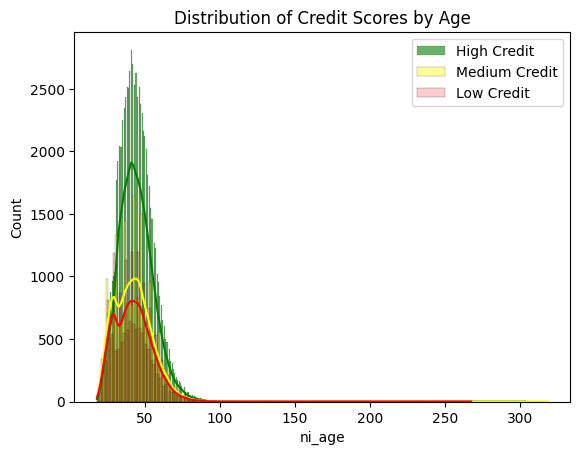

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data=df_high, x="ni_age", color="green", label="High Credit", kde=True, alpha = 0.6, )
sns.histplot(data=df_med, x="ni_age", color="yellow", label="Medium Credit", kde=True, alpha = 0.4, )
sns.histplot(data=df_low, x="ni_age", color="red", label="Low Credit", kde=True, alpha = 0.2, )

plt.title("Distribution of Credit Scores by Age")
plt.legend()
plt.show()

From the above graph, I can observe that alot of mid aged people have high credit scores. It is also seen that a large chunk of the data set has people with high credit. I also observe that the youngest population has a does not have a high credit.



### Distribution of Age based on Sales Channel

This code is to add the dataframe to the table to run sql queries.

In [27]:
query2 = train_df.select('cancel', 'sales_channel','ni_age')
query2.createOrReplaceTempView("data")

Adding relavant data into data frame.


In [28]:
df_broker = spark.sql('SELECT ni_age FROM data WHERE sales_channel == "Broker"').toPandas()
df_phone = spark.sql('SELECT ni_age FROM data WHERE sales_channel == "Phone"').toPandas()
df_online = spark.sql('SELECT ni_age FROM data WHERE sales_channel == "Online"').toPandas()

Visualize the histplot.

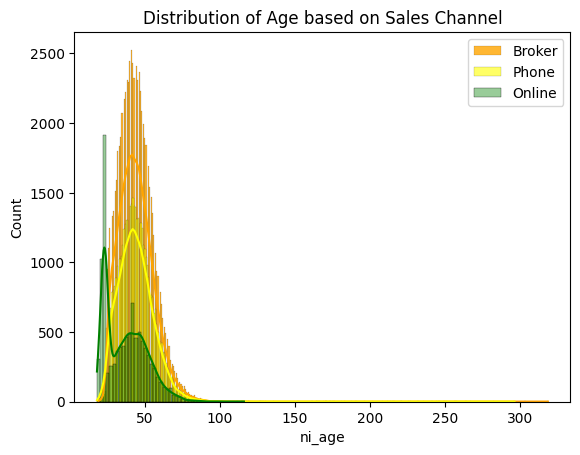

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.histplot(data=df_broker, x="ni_age", color="orange", label="Broker", kde=True, alpha=0.8, ax=ax)
sns.histplot(data=df_phone, x="ni_age", color="yellow", label="Phone", kde=True, alpha=0.6, ax=ax)
sns.histplot(data=df_online, x="ni_age", color="green", label="Online", kde=True, alpha=0.4, ax=ax)
ax.set(title="Distribution of Age based on Sales Channel")
ax.legend()
plt.show()


Here, I can observe that most of the population prefers "Broker" as the sales channel, followed by "Phone" and then "Online mode". It is also observed that most of the mid aged population prfers their sales channel to be a broker. I see that there is a huge drop between broker and phone as compared to between broker phone and online.

### Cancellation based on claim

This code is to add the dataframe to the table to run sql queries.

In [30]:
query3= train_df.select('claim_ind', 'cancel')
query3.createOrReplaceTempView("data")

Adding relavant data into data frame.


In [31]:
df3 = spark.sql('SELECT cancel, SUM(CASE WHEN claim_ind==0 THEN 1 END) AS No, SUM(CASE WHEN claim_ind==1 THEN 1 END) AS Yes FROM data GROUP BY cancel').toPandas()
df3

,cancel,No,Yes
0,1,6497,2124
1,2,19872,6338
2,0,69634,15407


Visualize the bargraph.

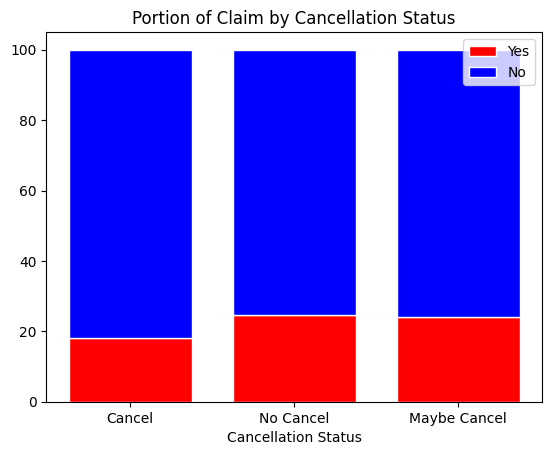

In [32]:
# Calculate percentages
df3['Total'] = df3['No'] + df3['Yes']
df3['No_Percentage'] = 100 * df3['No'] / df3['Total']
df3['Yes_Percentage'] = 100 * df3['Yes'] / df3['Total']

# Set up plot
barWidth = 0.75
names = ('No Cancel', 'Maybe Cancel', 'Cancel')

# Plot bars
plt.bar(df3['cancel'], df3['Yes_Percentage'], color='red', edgecolor='white', width=barWidth, label='Yes')
plt.bar(df3['cancel'], df3['No_Percentage'], bottom=df3['Yes_Percentage'], color='blue', edgecolor='white', width=barWidth, label='No')

# Set axis labels and legend
plt.xticks(df3['cancel'], names)
plt.xlabel("Cancellation Status")
plt.legend(loc='upper right', bbox_to_anchor=(1,1), ncol=1)

# Set title and display plot
plt.title("Portion of Claim by Cancellation Status")
plt.show()

From the above graph I can observe that a high proportion of population have their claim status as No for all types of cancellations. The proportion of Yes is low for people who cancel, while it increases and is pretty much same for people who do not cancel and who maybe cancel it.

### Cancellation based on Coverage type

This code is to add the dataframe to the table to run sql queries.

In [33]:
query4= train_df.select('coverage_type', 'cancel')
query4.createOrReplaceTempView("data")

Adding relavant data into data frame.


In [34]:
df4 = spark.sql('SELECT cancel, \
                SUM(CASE WHEN coverage_type=="A" THEN 1 END) AS A, \
                SUM(CASE WHEN coverage_type=="B" THEN 1 END) AS B, \
                SUM(CASE WHEN coverage_type=="C" THEN 1 END) AS C \
                FROM data \
                GROUP BY cancel').toPandas()
df4

,cancel,A,B,C
0,1,2819,2033,3766
1,2,8502,6229,11473
2,0,29621,20182,35237


Visualize the bar graph.

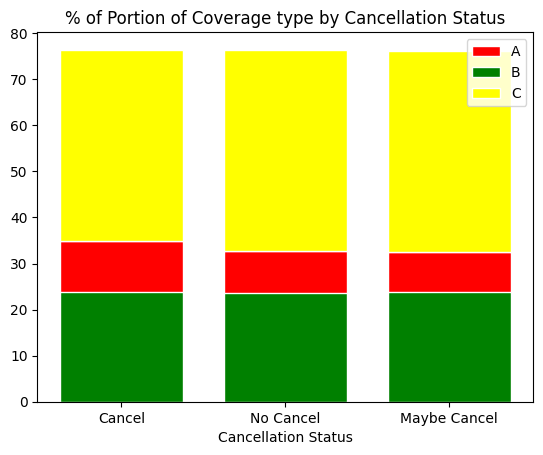

In [35]:
# Calculate percentages
df4['Total'] = df4['A'] + df4['B']+ df4['C']
df4['A_Percentage'] = 100 * df4['A'] / df4['Total']
df4['B_Percentage'] = 100 * df4['B'] / df4['Total']
df4['C_Percentage'] = 100 * df4['C'] / df4['Total']

# Set up plot
barWidth = 0.75
names = ('No Cancel', 'Maybe Cancel', 'Cancel')

# Plot bars
plt.bar(df4['cancel'], df4['A_Percentage'], color='red', edgecolor='white', width=barWidth, label='A')
plt.bar(df4['cancel'], df4['B_Percentage'], color='green', edgecolor='white', width=barWidth, label='B')
plt.bar(df4['cancel'], df4['C_Percentage'], bottom=df4['A_Percentage'], color='yellow', edgecolor='white', width=barWidth, label='C')

# Set axis labels and legend
plt.xticks(df4['cancel'], names)
plt.xlabel("Cancellation Status")
plt.legend(loc='upper right', bbox_to_anchor=(1,1), ncol=1)

# Set title and display plot
plt.title("% of Portion of Coverage type by Cancellation Status")
plt.show()

From the above plot I can observe that most of the population has coverage type as C for all options of cancellations. The next common coverage type is "A" but I see a dip in it while going from cancel to no cancel and maybe cancel. The least used coverage type is B which looks distributed much same for all the cancel types.

### Distribution of Age based on Claim

This code is to add the dataframe to the table to run sql queries.

In [36]:
query5 = train_df.select('cancel', 'claim_ind','ni_age')
query5.createOrReplaceTempView("data")

Adding relavant data into data frame.


In [37]:
df_no = spark.sql('SELECT ni_age FROM data WHERE claim_ind == 0.0').toPandas()
df_yes = spark.sql('SELECT ni_age FROM data WHERE claim_ind == 1.0').toPandas()

Visualize the histplot.

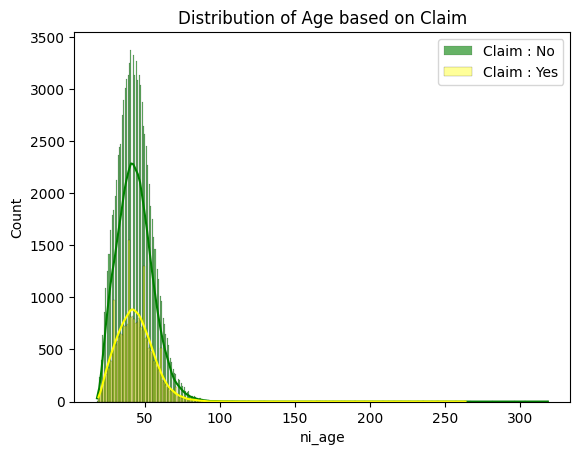

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data=df_no, x="ni_age", color="green", label="Claim : No", kde=True, alpha = 0.6, )
sns.histplot(data=df_yes, x="ni_age", color="yellow", label="Claim : Yes", kde=True, alpha = 0.4, )

plt.title("Distribution of Age based on Claim")
plt.legend()
plt.show()

I can see from the above graph that alot of the middle aged population has the claim as no while comparatively there are a very few yes. It is also observed that there is a large portion of the population have their claim as No.

# Columns

### zip_code

We think that zip codes don't really matter with policy cancelation and it cannot be imputed as there is no logic to it.

#### Train

In [39]:
train_df = train_df.drop("zip_code")

#### Test

In [40]:
test_df = test_df.drop("zip_code")

### house_color

It is not adding any significance to the prediction, hence we decide to drop it.

#### Train

In [41]:
train_df = train_df.drop("house_color")

#### Test

In [42]:
test_df = test_df.drop("house_color")

### ni_age

#### Train

There are policyholders with age>100, which has no logic so I am going to drop those values.

In [43]:
train_df.where(F.col('ni_age')>100).select(F.col('ni_age')).show()

+------------------+
|            ni_age|
+------------------+
|       109.1739787|
|             109.0|
|       170.4202618|
|             130.0|
|             103.0|
|170.69670469999997|
|       126.3848721|
|             109.0|
|       232.5749013|
|       208.4672868|
|235.91866890000003|
|       100.7423789|
|       212.0024936|
|       231.5875768|
|             109.0|
|             109.0|
|       267.5158861|
|             108.0|
|       119.0708671|
|       257.7570834|
+------------------+
only showing top 20 rows



In [44]:
train_df = train_df.filter(F.col('ni_age')<=100)

Here, I are going to calculate the average age present in the data set and then replace the null values with this average.

In [45]:
sum = train_df.select(F.sum(F.col('ni_age')).alias('sum')).show()
count = train_df.select(F.count(F.col('ni_age')).alias('count')).show()

+-----------------+
|              sum|
+-----------------+
|5203357.678989081|
+-----------------+

+------+
| count|
+------+
|119770|
+------+



In [46]:
# Calculating the average
avg = 5203357.678989081/119770
print(avg)

43.44458277522819


In [47]:
#fill null values of age columns
train_df = train_df.fillna(43.44, subset='ni_age')

#### Test

In [48]:
test_df.where(F.col('ni_age')>100).select(F.col('ni_age')).show()
test_df = test_df.filter(F.col('ni_age')<=100)

+------------------+
|            ni_age|
+------------------+
|       192.7261281|
|108.98347340000002|
|             101.0|
|       204.7945161|
|             117.0|
|       111.3880584|
|             109.0|
|             104.0|
|       223.0520549|
|        124.189555|
|       205.1218257|
|             107.0|
|             103.0|
|        111.192017|
|       342.1057073|
|             102.0|
|             105.0|
|             103.0|
|             101.0|
|             110.0|
+------------------+
only showing top 20 rows



In [49]:
sum = test_df.select(F.sum(F.col('ni_age')).alias('sum')).show()
count = test_df.select(F.count(F.col('ni_age')).alias('count')).show()

+-------------------+
|                sum|
+-------------------+
|1.496662345751464E7|
+-------------------+

+------+
| count|
+------+
|344315|
+------+



In [50]:
# Calculating the average
avg = 1.496662345751464E7/344315
print(avg)

43.46782294560109


In [51]:
#fill null values of age columns
test_df = test_df.fillna(43.46, subset='ni_age')

### len_at_res

#### Train

First, I am going to check the minimum and maximum values of len_at_res present in the data set.

In [52]:
train_df.select(F.max(F.col('len_at_res'))).show()
train_df.select(F.min(F.col('len_at_res'))).show()

+---------------+
|max(len_at_res)|
+---------------+
|    49.98815525|
+---------------+

+---------------+
|min(len_at_res)|
+---------------+
|            2.0|
+---------------+



Since there were no out of range values, I will calculate the average value of the len_at_res and then repolace the null values with this average.

In [53]:
sum_len = train_df.select(F.sum(F.col('len_at_res')).alias('sum_len')).show()
count_len = train_df.select(F.count(F.col('len_at_res')).alias('count_len')).show()

+------------------+
|           sum_len|
+------------------+
|1818620.3752815635|
+------------------+

+---------+
|count_len|
+---------+
|   119658|
+---------+



In [54]:
# Calculating the average
avg = 1818620.3752815635/ 119658
print(avg)

15.198485477624258


In [55]:
#fill null values of age columns
train_df = train_df.fillna(15.19, subset='len_at_res')

#### Test

In [56]:
test_df.select(F.max(F.col('len_at_res'))).show()
test_df.select(F.min(F.col('len_at_res'))).show()

+---------------+
|max(len_at_res)|
+---------------+
|    49.99853725|
+---------------+

+---------------+
|min(len_at_res)|
+---------------+
|            1.0|
+---------------+



In [57]:
sum_len = test_df.select(F.sum(F.col('len_at_res')).alias('sum_len')).show()
count_len = test_df.select(F.count(F.col('len_at_res')).alias('count_len')).show()

+-----------------+
|          sum_len|
+-----------------+
|5234211.782432109|
+-----------------+

+---------+
|count_len|
+---------+
|   344020|
+---------+



In [58]:
# Calculating the average
avg = 5234211.782432109/344020
print(avg)

15.214847341526973


In [59]:
#fill null values of age columns
test_df = test_df.fillna(15.21, subset='len_at_res')

### credit

#### Train

I calculate the total count of values present in credit.

In [60]:
train_df.select(F.col('credit')).groupBy('credit').count().orderBy('count', ascending=False).show()

+------+-----+
|credit|count|
+------+-----+
|  high|74031|
|medium|26173|
|   low|19464|
|  NULL|  102|
+------+-----+



The common credit is high, so I am going to impute the missing values with high.


In [61]:
#fill null values of binary columns
train_df = train_df.fillna('high', subset='credit')

I have first used the String Indexer before transforming it by OneHotEncoder as this column is of type String.


In [62]:
from pyspark.ml.feature import PolynomialExpansion
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorIndexer
from pyspark.mllib.util import MLUtils
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [63]:
indexer_credit = StringIndexer(inputCol="credit", outputCol="credit_StInx")
train_df = indexer_credit.fit(train_df).transform(train_df)
encoder_credit = OneHotEncoder(inputCol="credit_StInx", outputCol="credit_OHE")
train_df = encoder_credit.fit(train_df).transform(train_df)

#### Test

In [64]:
test_df.select(F.col('credit')).groupBy('credit').count().orderBy('count', ascending=False).show()

+------+------+
|credit| count|
+------+------+
|  high|212543|
|medium| 74942|
|   low| 56541|
|  NULL|   289|
+------+------+



In [65]:
#fill null values of binary columns
test_df = test_df.fillna('high', subset='credit')

In [66]:
indexer_credit = StringIndexer(inputCol="credit", outputCol="credit_StInx")
test_df = indexer_credit.fit(test_df).transform(test_df)
encoder_credit = OneHotEncoder(inputCol="credit_StInx", outputCol="credit_OHE")
test_df = encoder_credit.fit(test_df).transform(test_df)

### coverage_type

#### Train

first, I will calculate the count of values present in coverage_type.

In [67]:
train_df.select(F.col('coverage_type')).groupBy('coverage_type').count().orderBy('count', ascending=False).show()

+-------------+-----+
|coverage_type|count|
+-------------+-----+
|            C|50370|
|            A|40865|
|            B|28397|
|         NULL|  138|
+-------------+-----+



I can see that the most common coverage type is 'C', so I will replace all the null values with "C".

In [68]:
train_df = train_df.fillna('C', subset='coverage_type')

I have first used the String Indexer before transforming it by OneHotEncoder as this column is of type String.


In [69]:
indexer_coverage_type= StringIndexer(inputCol="coverage_type", outputCol="coverage_type_StInx")
train_df = indexer_coverage_type.fit(train_df).transform(train_df)
encoder_coverage_type = OneHotEncoder(inputCol="coverage_type_StInx", outputCol="coverage_type_OHE")
train_df = encoder_coverage_type.fit(train_df).transform(train_df)

#### Test

In [70]:
test_df.select(F.col('coverage_type')).groupBy('coverage_type').count().orderBy('count', ascending=False).show()

+-------------+------+
|coverage_type| count|
+-------------+------+
|            C|144283|
|            A|117136|
|            B| 82581|
|         NULL|   315|
+-------------+------+



In [71]:
#fill null values of binary columns
test_df = test_df.fillna('C', subset='coverage_type')

In [72]:
indexer_coverage_type= StringIndexer(inputCol="coverage_type", outputCol="coverage_type_StInx")
test_df = indexer_coverage_type.fit(test_df).transform(test_df)
encoder_coverage_type = OneHotEncoder(inputCol="coverage_type_StInx", outputCol="coverage_type_OHE")
test_df = encoder_coverage_type.fit(test_df).transform(test_df)

### dwelling_type

It is not adding any significance to the prediction, hence I decide to drop it.

#### Train

In [73]:
train_df.groupby("dwelling_type").pivot("cancel").count().show()

+-------------+-----+----+-----+
|dwelling_type|    0|   1|    2|
+-------------+-----+----+-----+
|         NULL|   81|  15|   32|
|        Condo|19998|2163| 6524|
|        House|48614|4553|14009|
|       Tenant|16265|1887| 5629|
+-------------+-----+----+-----+



In [74]:
train_df = train_df.drop("dwelling_type")

#### Test

In [75]:
test_df = test_df.drop("dwelling_type")

### premium

It is not adding any significance to the prediction, hence I decide to drop it.

#### Train

In [76]:
train_df = train_df.drop("premium")

#### Test

In [77]:
test_df = test_df.drop("premium")

### ni_gender

It is not adding any significance to the prediction, hence I decide to drop it.

#### Train

In [78]:
train_df = train_df.drop("ni_gender")

#### Test

In [79]:
test_df = test_df.drop("ni_gender")

### sales_channel

#### Train

First, I will calculate the count of value spresent in sales channel.

In [80]:
train_df.select(F.col('sales_channel')).groupBy('sales_channel').count().orderBy('count', ascending=False).show()

+-------------+-----+
|sales_channel|count|
+-------------+-----+
|       Broker|69455|
|        Phone|40003|
|       Online|10194|
|         NULL|  118|
+-------------+-----+



I observe that the most common sales channel is Broker, so I will replace the null value with "Broker".

In [81]:
#fill null values
train_df = train_df.fillna('Broker', subset='sales_channel')

I have first used the String Indexer before transforming it by OneHotEncoder as this column is of type String.


In [82]:
indexer_salesChanel = StringIndexer(inputCol="sales_channel", outputCol="sales_channel_StInx")
train_df = indexer_salesChanel.fit(train_df).transform(train_df)
encoder_salesChanel = OneHotEncoder(inputCol="sales_channel_StInx", outputCol="sales_channel_OHE")
train_df = encoder_salesChanel.fit(train_df).transform(train_df)

#### Test

In [83]:
test_df.select(F.col('sales_channel')).groupBy('sales_channel').count().orderBy('count', ascending=False).show()

+-------------+------+
|sales_channel| count|
+-------------+------+
|       Broker|199867|
|        Phone|114739|
|       Online| 29385|
|         NULL|   324|
+-------------+------+



In [84]:
#fill null values
test_df = test_df.fillna('Broker', subset='sales_channel')

In [85]:
indexer_salesChanel = StringIndexer(inputCol="sales_channel", outputCol="sales_channel_StInx")
test_df = indexer_salesChanel.fit(test_df).transform(test_df)
encoder_salesChanel = OneHotEncoder(inputCol="sales_channel_StInx", outputCol="sales_channel_OHE")
test_df = encoder_salesChanel.fit(test_df).transform(test_df)

### ni_marital_status

It is not adding any significance to the prediction, hence I decide to drop it.

#### Train

In [86]:
train_df = train_df.drop("ni_marital_status")

#### Test

In [87]:
test_df = test_df.drop("ni_marital_status")

### n_adults

#### Train

In [88]:
train_df.select(F.max(F.col('n_adults'))).show()

+-------------+
|max(n_adults)|
+-------------+
|         10.0|
+-------------+



Here, I will calculate the average number of adults present in the dataset and then replace the null values with this average value.

In [89]:
sum_adults = train_df.select(F.sum(F.col('n_adults')).alias('sum_adults')).show()
count_adults = train_df.select(F.count(F.col('n_adults')).alias('count_adults')).show()

+----------+
|sum_adults|
+----------+
|  255464.0|
+----------+

+------------+
|count_adults|
+------------+
|      119678|
+------------+



In [90]:
# Calculating the average
avg = 255464.0/119908
print(avg)

2.130500050038363


Rounding it to 2

In [91]:
train_df = train_df.fillna(2.0, subset='n_adults')

#### Test

In [92]:
test_df.select(F.max(F.col('n_adults'))).show()

+-------------+
|max(n_adults)|
+-------------+
|         12.0|
+-------------+



In [93]:
sum_adults = test_df.select(F.sum(F.col('n_adults')).alias('sum_adults')).show()
count_adults = test_df.select(F.count(F.col('n_adults')).alias('count_adults')).show()

+----------+
|sum_adults|
+----------+
|  734146.0|
+----------+

+------------+
|count_adults|
+------------+
|      343993|
+------------+



In [94]:
# Calculating the average
avg = 734146.0/343993
print(avg)

2.1341887770972083


In [95]:
test_df = test_df.fillna(2.0, subset='n_adults')

### n_children

#### Train

Here, I will calculate the average number of children present in the dataset and then replace the null values with this average value.

In [96]:
sum_children = train_df.select(F.sum(F.col('n_children')).alias('sum_children')).show()
count_children = train_df.select(F.count(F.col('n_children')).alias('count_children')).show()

+------------+
|sum_children|
+------------+
|    207593.0|
+------------+

+--------------+
|count_children|
+--------------+
|        119675|
+--------------+



In [97]:
# Calculating the average
avg =207593.0 / 119675
print(avg)

1.734639649049509


Rounding 1.7 to 2

In [98]:
train_df = train_df.fillna(2.0, subset='n_children')

#### Test

In [99]:
sum_children = test_df.select(F.sum(F.col('n_children')).alias('sum_children')).show()
count_children = test_df.select(F.count(F.col('n_children')).alias('count_children')).show()

+------------+
|sum_children|
+------------+
|    596047.0|
+------------+

+--------------+
|count_children|
+--------------+
|        343996|
+--------------+



In [100]:
# Calculating the average
avg =596047.0 /343996
print(avg)

1.7327149152897128


In [101]:
test_df = test_df.fillna(2.0, subset='n_children')

### tenure

#### Train

Here, I will calculate the average tenure present in the dataset and then replace the null values with this average value.

In [102]:
sum_tenure = train_df.select(F.sum(F.col('tenure')).alias('sum_tenure')).show()
count_tenure = train_df.select(F.count(F.col('tenure')).alias('count_tenure')).show()

+----------+
|sum_tenure|
+----------+
| 1394639.0|
+----------+

+------------+
|count_tenure|
+------------+
|      119646|
+------------+



In [103]:
# Calculating the average
avg =1394639.0/119646
print(avg)

11.656377981712719


In [104]:
train_df = train_df.fillna(11.65, subset='tenure')

#### Test

In [105]:
sum_tenure = test_df.select(F.sum(F.col('tenure')).alias('sum_tenure')).show()
count_tenure = test_df.select(F.count(F.col('tenure')).alias('count_tenure')).show()

+----------+
|sum_tenure|
+----------+
| 4013202.0|
+----------+

+------------+
|count_tenure|
+------------+
|      343992|
+------------+



In [106]:
# Calculating the average
avg =4013202.0/343992
print(avg)

11.666556198981372


In [107]:
test_df = test_df.fillna(11.65, subset='tenure')

### claim_ind

#### Train

Here, I will first count the values of claim_ind present in the dataset.

In [108]:
train_df.select(F.col('claim_ind')).groupBy('claim_ind').count().orderBy('count', ascending=False).show()

+---------+-----+
|claim_ind|count|
+---------+-----+
|      0.0|95814|
|      1.0|23829|
|     NULL|  127|
+---------+-----+



I can observe that 0.0 is the most common claim_ind so I will replace the null values with 0.0

In [109]:
train_df = train_df.fillna(0.0, subset='claim_ind')

In [110]:
encoder_claim = OneHotEncoder(inputCol="claim_ind", outputCol="claim_ind_OHE")
train_df = encoder_claim.fit(train_df).transform(train_df)

#### Test

In [111]:
test_df.select(F.col('claim_ind')).groupBy('claim_ind').count().orderBy('count', ascending=False).show()

+---------+------+
|claim_ind| count|
+---------+------+
|      0.0|275034|
|      1.0| 68957|
|     NULL|   324|
+---------+------+



In [112]:
 #fill null values
test_df = test_df.fillna(0.0, subset='claim_ind')

In [113]:
encoder_claim = OneHotEncoder(inputCol="claim_ind", outputCol="claim_ind_OHE")
test_df = encoder_claim.fit(test_df).transform(test_df)

# Transformation

Here, I have defind a new train dataset along with continous columns and continous features to perfom the transformation.
I have also used Vector assembler.

## Train

In [114]:
new_train_df = train_df.select('year', "ni_age", "len_at_res", "credit_OHE", "coverage_type_OHE", "sales_channel_OHE", "n_adults", "n_children", "tenure", "claim_ind",'cancel')

In [115]:
CONTINUOUS_COLUMNS = ['year', "ni_age", "len_at_res", "credit_OHE", "coverage_type_OHE", "sales_channel_OHE", "n_adults", "n_children", "tenure", "claim_ind" ]

In [116]:
continuous_features = VectorAssembler(inputCols=CONTINUOUS_COLUMNS, outputCol="continuous_features")

In [117]:
new_train_df = continuous_features.transform(new_train_df)

## Test

In [118]:
test_df = continuous_features.transform(test_df)

# Modeling

I are using the Random Forest Classifier model on the training and testing dataset.

In [119]:
# Import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassifier

In [120]:
# Create model
rfc = RandomForestClassifier(featuresCol='continuous_features', labelCol='cancel', predictionCol='cancelprediction',
                            maxMemoryInMB = 3000, maxDepth = 10, maxBins = 96,
                            bootstrap = True, numTrees = 50)
rfc.setThresholds([3, 1, 2])

rfcmod = rfc.fit(new_train_df)

Performing predictions on both the training and testing data set.

In [121]:
# predictions
train_results = rfcmod.transform(new_train_df)
test_results = rfcmod.transform(test_df)

In [122]:
train_results = train_results.toPandas()

In [123]:
test_results = test_results.toPandas()

## Test Results

Below is the code to get test results for testing data set.

In [124]:
from sklearn.metrics import classification_report
print(classification_report(test_results['cancel'], test_results['cancelprediction'], digits=3))

              precision    recall  f1-score   support

           0      0.764     0.884     0.819    244037
           1      0.213     0.197     0.205     24752
           2      0.518     0.268     0.354     75526

    accuracy                          0.699    344315
   macro avg      0.498     0.450     0.459    344315
weighted avg      0.670     0.699     0.673    344315



## Train Results

Below is the code to get test results for training data set.

In [125]:
from sklearn.metrics import classification_report
print(classification_report(train_results['cancel'], train_results['cancelprediction'], digits=3))

              precision    recall  f1-score   support

           0      0.774     0.895     0.830     84958
           1      0.293     0.277     0.284      8618
           2      0.571     0.291     0.385     26194

    accuracy                          0.718    119770
   macro avg      0.546     0.488     0.500    119770
weighted avg      0.695     0.718     0.694    119770



# Printing the Tree

Below code helps us to print the tree.

In [126]:
# assuming you have trained a RandomForestClassificationModel named 'rfcmodel'

# access the individual decision trees in the ensemble
trees = rfcmod.trees

# iterate over the trees in the ensemble and print the nodes of each tree
for i, tree in enumerate(trees):
    print(f"Decision Tree #{i + 1}")
    print(tree.toDebugString)


Streaming output truncated to the last 5000 lines.
            Predict: 2.0
        Else (feature 1 > 35.5)
         If (feature 11 <= 13.5)
          Predict: 0.0
         Else (feature 11 > 13.5)
          If (feature 11 <= 14.5)
           If (feature 9 <= 2.5)
            Predict: 2.0
           Else (feature 9 > 2.5)
            Predict: 0.0
          Else (feature 11 > 14.5)
           Predict: 0.0
     Else (feature 9 > 3.5)
      If (feature 12 <= 0.5)
       If (feature 10 <= 3.5)
        If (feature 1 <= 60.5)
         If (feature 2 <= 14.097945715)
          Predict: 0.0
         Else (feature 2 > 14.097945715)
          If (feature 9 <= 5.5)
           If (feature 11 <= 19.5)
            Predict: 0.0
           Else (feature 11 > 19.5)
            Predict: 2.0
          Else (feature 9 > 5.5)
           Predict: 0.0
        Else (feature 1 > 60.5)
         If (feature 11 <= 20.5)
          If (feature 2 <= 8.0055158065)
           Predict: 2.0
          Else (feature 2 > 8.

# Interpretability and Discussion




On closely calculating the cancellations based on coverage type I found that  coverage A had the highest cancellation percentage at 72% and C had the lowest at 69% , however C saw the most cancellations at 35237 cases and also a may cancel at 11473. This indicates a high dissatisfaction with the coverage type C. Measures must be taken by the company to improve the coverage type C and further introduce marketing strategies like incentivising policy renewals in alignment with the rate of cancellations in all three categories. Furthermore brokers can make sure to put in extra efforts of maintaining an healthy relationship with policy holders of coverage type C . To do an root cause analysis , factors like claims settlement of all the coverage type can be analysed to understand customer behaviour

The insurance company should make a concerted effort to communicate regularly via the brokers with policyholders, providing them with relevant information about their policies, and addressing any concerns they may have.